In [10]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from keras import layers
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path

import re
from IPython import display

In [11]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


### Preprocess Text

In [12]:
dictionary_path = './dictionary'
vocab = np.load(dictionary_path + '/vocab.npy')
print('there are {} vocabularies in total'.format(len(vocab)))

word2Id_dict = dict(np.load(dictionary_path + '/word2Id.npy'))
id2word_dict = dict(np.load(dictionary_path + '/id2Word.npy'))
print('Word to id mapping, for example: %s -> %s' % ('flower', word2Id_dict['flower']))
print('Id to word mapping, for example: %s -> %s' % ('1', id2word_dict['1']))
print('Tokens: <PAD>: %s; <RARE>: %s' % (word2Id_dict['<PAD>'], word2Id_dict['<RARE>']))

there are 5427 vocabularies in total
Word to id mapping, for example: flower -> 1
Id to word mapping, for example: 1 -> flower
Tokens: <PAD>: 5427; <RARE>: 5428


In [13]:
def sent2IdList(line, MAX_SEQ_LENGTH=20):
    MAX_SEQ_LIMIT = MAX_SEQ_LENGTH
    padding = 0
    
    # data preprocessing, remove all puntuation in the texts
    prep_line = re.sub('[%s]' % re.escape(string.punctuation), ' ', line.rstrip())
    prep_line = prep_line.replace('-', ' ')
    # prep_line = prep_line.replace('-', ' ') # TODO: origin line
    prep_line = prep_line.replace('_', ' ')
    prep_line = prep_line.replace('  ', ' ')
    prep_line = prep_line.replace('.', '')
    # transfrom string to char sequence
    tokens = prep_line.split(' ')
    tokens = [
        tokens[i] for i in range(len(tokens))
        if tokens[i] != ' ' and tokens[i] != ''
    ]
    l = len(tokens)
    padding = MAX_SEQ_LIMIT - l
    
    # make sure length of each text is equal to MAX_SEQ_LENGTH, and replace the less common word with <RARE> token
    for i in range(padding):
        tokens.append('<PAD>')
    # transform char sequence to id sequence
    line = [
        word2Id_dict[tokens[k]]
        if tokens[k] in word2Id_dict else word2Id_dict['<RARE>']
        for k in range(len(tokens))
    ]

    return line

text = "the flower shown has yellow anther red pistil and bright red petals."
print(text)
print(sent2IdList(text))

the flower shown has yellow anther red pistil and bright red petals.
['9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427']


### Dataset

In [14]:
data_path = './datasets/'
df = pd.read_pickle(data_path + '/text2ImgData.pkl')
num_training_sample = len(df)
n_images_train = num_training_sample
print('There are %d image in training data' % (n_images_train))

There are 7370 image in training data


In [15]:
df.head(5)

,Captions,ImagePath
ID,,
6734,"[[9, 2, 17, 9, 1, 6, 14, 13, 18, 3, 41, 8, 11,...",./102flowers/image_06734.jpg
6736,"[[4, 1, 5, 12, 2, 3, 11, 31, 28, 68, 106, 132,...",./102flowers/image_06736.jpg
6737,"[[9, 2, 27, 4, 1, 6, 14, 7, 12, 19, 5427, 5427...",./102flowers/image_06737.jpg
6738,"[[9, 1, 5, 8, 54, 16, 38, 7, 12, 116, 325, 3, ...",./102flowers/image_06738.jpg
6739,"[[4, 12, 1, 5, 29, 11, 19, 7, 26, 70, 5427, 54...",./102flowers/image_06739.jpg


In [16]:
def idList2Text(idList):
    text = ""
    for id in idList:
        if(id == "5427"): break
        elif(id == "5428"): text += "[UNK] "
        else: text += id2word_dict[id] + ' '
    return text.strip()

In [17]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

text = idList2Text(['9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5428', '5427', '5427', '5427', '5427', '5427', '5427', '5427'])
tokens = tokenizer.encode(text, add_special_tokens=True, padding='longest')

print("Original Text:", text)
print("Tokenized IDs:", tokens)
print("Token length:", len(tokens))
print("Decoded Tokens:", tokenizer.decode(tokens))

c:\Users\johnson\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Original Text: the flower shown has yellow anther red pistil and bright red petals [UNK]
Tokenized IDs: [101, 1996, 6546, 3491, 2038, 3756, 14405, 5886, 2417, 14255, 16643, 2140, 1998, 4408, 2417, 15829, 100, 102]
Token length: 18
Decoded Tokens: [CLS] the flower shown has yellow anther red pistil and bright red petals [UNK] [SEP]


### Dataset API

In [18]:
# in this competition, you have to generate image in size 64x64x3
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3

def stage1_data_generator(caption, image_path):
    # load in the image according to image path
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([None, None, 3])
    # img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    # img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    img = tf.image.resize(img, size=[64, 64])
    img.set_shape([64, 64, 3])

    #TODO: data augmentation and normalize value to [-1, 1]
    img = (img * 2) - 1
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
    # prob = tf.random.uniform(shape=[1], minval=0, maxval=1)
    # if(prob >= 0.4 and prob < 0.7):
    #     img = tf.image.rot90(img, k=1)
    # elif(prob >= 0.7):
    #     img = tf.image.rot90(img, k=3)
    # img = tf.image.random_saturation(img, lower=0.9, upper=1.1)
    # img = tf.image.random_hue(img, max_delta=0.1)    
    
    return img, caption

def stage2_data_generator(caption, image_path):
    # load in the image according to image path
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([None, None, 3])
    # img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    # img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    img = tf.image.resize(img, size=[256, 256])
    img.set_shape([256, 256, 3])

    #TODO: data augmentation and normalize value to [-1, 1]
    img = (img * 2) - 1
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
    # img = tf.image.random_saturation(img, lower=0.9, upper=1.1)
    # img = tf.image.random_hue(img, max_delta=0.2)    
    # prob = tf.random.uniform(shape=[1], minval=0, maxval=1)
    # if(prob > 0.7):
    #     img = tf.image.central_crop(img, central_fraction=0.8)
    
    return img, caption

def dataset_generator(filenames, batch_size):
    df = pd.read_pickle(filenames)

    captions = df['Captions'].values
    image_path = df['ImagePath'].values
    textCaptionList = []
    # imagePathList = []

    # TODO: only choose one of descriptions to train, total descriptions is 70504
    for i in range(len(captions)):
        # cnt = 0
        # for j in range(len(captions[i])):
        #     textCaptionList.append(idList2Text(captions[i][j]))
        #     imagePathList.append(image_path[i])
        #     cnt += 1
        #     if(cnt == 2): break
        textCaptionList.append(idList2Text(random.choice(captions[i])))

    # imagePathList = np.asarray(imagePathList)

    captionList = [tokenizer.encode(text, add_special_tokens=True) for text in textCaptionList]
    max_token_length = max(len(tokens) for tokens in captionList)
    paddedCaptionList = tf.keras.preprocessing.sequence.pad_sequences(captionList, padding='post', maxlen=max_token_length)
    paddedCaptionList = np.asarray(paddedCaptionList).astype(int)

    # check whether padded caption has same length
    for pad_caption in paddedCaptionList:
        if(len(pad_caption) != max_token_length): print(len(pad_caption))
        
    print(f"Dataset size: {len(paddedCaptionList)}, Caption Length: {len(paddedCaptionList[0])}")
    # assume that each row of `features` corresponds to the same row as `labels`.
    assert len(paddedCaptionList) == len(image_path)
    # assert len(paddedCaptionList) == len(imagePathList)
    assert paddedCaptionList.dtype == int

    dataset_stage1 = tf.data.Dataset.from_tensor_slices((paddedCaptionList, image_path))
    dataset_stage1 = dataset_stage1.map(stage1_data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset_stage1 = dataset_stage1.shuffle(len(paddedCaptionList)).batch(batch_size, drop_remainder=True)
    dataset_stage1 = dataset_stage1.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    dataset_stage2 = tf.data.Dataset.from_tensor_slices((paddedCaptionList, image_path))
    dataset_stage2 = dataset_stage2.map(stage2_data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset_stage2 = dataset_stage2.shuffle(len(paddedCaptionList)).batch(batch_size, drop_remainder=True)
    dataset_stage2 = dataset_stage2.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset_stage1, dataset_stage2

In [19]:
hparas = {
    'MAX_SEQ_LENGTH': 20,                     # maximum sequence length
    'EMBED_DIM': 128,                         # word embedding dimension
    'VOCAB_SIZE': len(word2Id_dict),          # size of dictionary of captions
    'RNN_HIDDEN_SIZE': 128,                   # number of RNN neurons
    'Z_DIM': 128,                             # random noise z dimension
    'DENSE_DIM': 1024,                         # number of neurons in dense layer
    'IMAGE_SIZE': [64, 64, 3],                # render image size
    'BATCH_SIZE': 64,
    'LR': 1e-4,                               
    'LR_DECAY': 0.5,
    'BETA_1': 0.5,
    'N_EPOCH': 100,
    'N_SAMPLE': num_training_sample,          # size of training data
    'CHECKPOINTS_DIR': './checkpoints/demo',  # checkpoint path
    'PRINT_FREQ': 5,                         # printing frequency of loss
    'PRINT_FREQ_2': 5,
    'CRITIC_1': 5,                            # the number of iterations of the critic per generator iteration
    'CRITIC_2': 5
}

In [20]:
# dataset = dataset_generator(data_path + '/text2ImgData.pkl', hparas['BATCH_SIZE'], training_data_generator)
dataset_stage1, dataset_stage2 = dataset_generator(data_path + '/text2ImgData.pkl', hparas['BATCH_SIZE'])

Dataset size: 7370, Caption Length: 29


Stage 1 data generate: 

tf.Tensor(
[  101  1996 15829  1997  1996  6546  2024  5061  1999  3609  1998  2038
  2019  2503  2008  2003  3756   102     0     0     0     0     0     0
     0     0     0     0     0], shape=(29,), dtype=int32)
[CLS] the petals of the flower are pink in color and has an inside that is yellow [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Image Scope: -1.03127920627594 ~ 0.8539419174194336


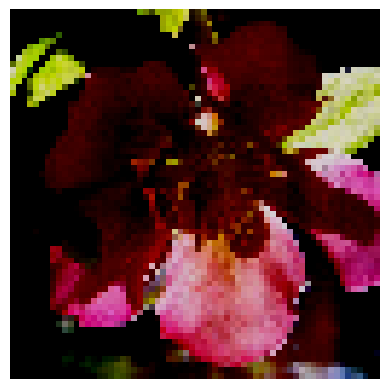


tf.Tensor(
[  101  1996 15829  2006  2023  6546  2024  6999  1998  2119  5061  1998
 18237  1999  3609   102     0     0     0     0     0     0     0     0
     0     0     0     0     0], shape=(29,), dtype=int32)
[CLS] the petals on this flower are folded and both pink and peach in color [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Image Scope: -1.0911146402359009 ~ 0.9773622751235962


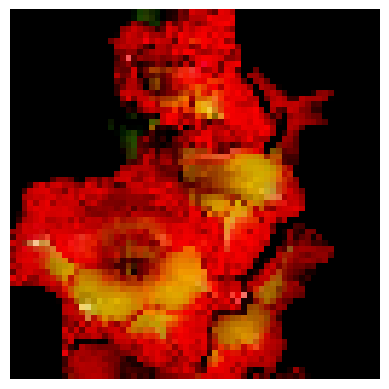

Stage 2 data generatre: 

tf.Tensor(
[  101  1996  5061  6546  2038 19660  9004  2389  2008  2024  3569  2011
  2665 21877 24598  2140   102     0     0     0     0     0     0     0
     0     0     0     0     0], shape=(29,), dtype=int32)
[CLS] the pink flower has fused petal that are supported by green pedicel [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Image Scope: -0.9932957887649536 ~ 1.0055049657821655


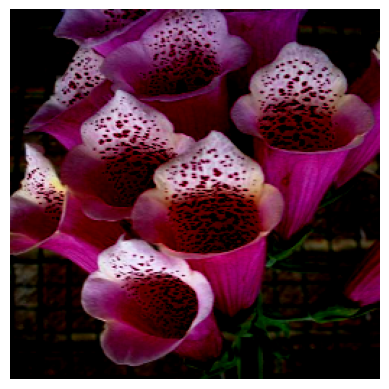


tf.Tensor(
[  101  1037  2312  1051 19722  2571  3139  1999  2116  4714  2210  6379
 15829   102     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0], shape=(29,), dtype=int32)
[CLS] a large ovule covered in many tiny little purple petals [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Image Scope: -1.0162911415100098 ~ 1.1615227460861206


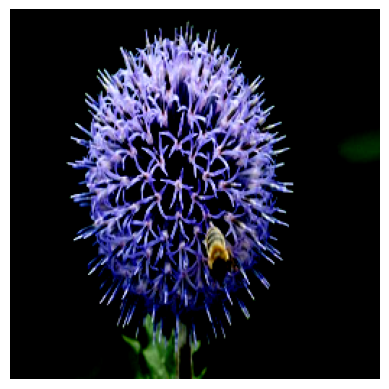

In [21]:
# Check result
import time

print("Stage 1 data generate: ")
count = 0
for idx, (image_batch, caption_batch) in enumerate(dataset_stage1):
    for image, caption in zip(image_batch, caption_batch):
        # print(caption.numpy().decode('utf-8'))
        print()
        print(caption)
        print(tokenizer.decode(caption))
        image = image.numpy()
        print(f"Image Scope: {np.min(image)} ~ {np.max(image)}")
        image = np.clip(image, 0, 1)
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        count += 1
        break
    if(count == 2): break

print("Stage 2 data generatre: ")
count = 0
for idx, (image_batch, caption_batch) in enumerate(dataset_stage2):
    for image, caption in zip(image_batch, caption_batch):
        # print(caption.numpy().decode('utf-8'))
        print()
        print(caption)
        print(tokenizer.decode(caption))
        image = image.numpy()
        print(f"Image Scope: {np.min(image)} ~ {np.max(image)}")
        image = np.clip(image, 0, 1)
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        count += 1
        break
    if(count == 2): break

### Text Encoder

In [22]:
from transformers import TFBertModel

class TextEncoder(tf.keras.Model):
    """
    Encode text (a caption) into hidden representation
    input: text
    output: embedding, or hidden representation of input text in dimension of RNN_HIDDEN_SIZE
    """
    def __init__(self, hparas):
        super(TextEncoder, self).__init__()
        self.hparas = hparas
        self.batch_size = self.hparas['BATCH_SIZE']
        self.bert = TFBertModel.from_pretrained('bert-base-uncased')

    def call(self, text_ids):
        hidden = self.bert(text_ids)[0]

        return hidden[:, 0, :]

### Generator

In [23]:
class CA_NET(tf.keras.Model):
    def __init__(self):
        super(CA_NET, self).__init__()
        self.condition_dim = hparas['Z_DIM']
        self.relu = layers.ReLU()
        self.flatten = layers.Flatten()
        self.fc_mu = layers.Dense(units=self.condition_dim, use_bias=True, activation='relu', name='mu_fc')
        self.fc_logvar = layers.Dense(units=self.condition_dim, use_bias=True, activation='relu', name='logvar_fc')

    def encode(self, text_embedding):
        mu = self.fc_mu(text_embedding)
        logvar = self.fc_logvar(text_embedding)
        return mu, logvar

    def reparametrize(self, mu, logvar):
        std = tf.exp(0.5 * logvar)
        eps = tf.random.normal(tf.shape(std), mean=0.0, stddev=1.0, dtype=tf.float32)
        return mu + eps * std

    def call(self, text_embedding):
        text_embedding = self.flatten(text_embedding)
        mu, logvar = self.encode(text_embedding)
        c_code = self.reparametrize(mu, logvar)
        return c_code, mu, logvar

In [24]:
class Generator_stage1(tf.keras.Model):
    """
    Generate fake image based on given text(hidden representation) and noise z
    input: text and noise
    output: fake image with size 64*64*3
    """
    def __init__(self, hparas):
        super(Generator_stage1, self).__init__()
        self.hparas = hparas
        # self.ca_net = CA_NET()
        # self.ca_preprocess = keras.Sequential([
        #     layers.Dense(units=4*4*1024, use_bias=False),
        #     layers.BatchNormalization(),
        #     layers.ReLU(),
        #     layers.Reshape((4, 4, 1024))
        # ]) # (4, 4, 1024)
        # self.generate = keras.Sequential([
        #     layers.UpSampling2D(size=(2, 2), interpolation='nearest'),
        #     layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='SAME', use_bias=False),
        #     layers.BatchNormalization(),
        #     layers.ReLU(), # (8, 8, 512)
        #     layers.UpSampling2D(size=(2, 2), interpolation='nearest'),
        #     layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='SAME', use_bias=False),
        #     layers.BatchNormalization(),
        #     layers.ReLU(), # (16, 16, 256)
        #     layers.UpSampling2D(size=(2, 2), interpolation='nearest'),
        #     layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='SAME', use_bias=False),
        #     layers.BatchNormalization(),
        #     layers.ReLU(), # (32, 32, 128)
        #     layers.UpSampling2D(size=(2, 2), interpolation='nearest'),
        #     layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='SAME', use_bias=False),
        #     layers.BatchNormalization(),
        #     layers.ReLU(), # (64, 64, 64)
        #     layers.Conv2D(filters=3, kernel_size=3, strides=1, padding='SAME', activation=keras.activations.tanh),
        # ]) # (64, 64, 3)
        self.text_preprocess = keras.Sequential([
            layers.Dense(units=hparas['EMBED_DIM']),
            layers.Reshape((1, 1, hparas['EMBED_DIM'])),
            layers.Conv2DTranspose(filters=512, kernel_size=3, strides=4, padding='SAME'),
            layers.BatchNormalization(),
            layers.ReLU(),
        ]) # (4, 4, 512)
        self.noise_preprocess = keras.Sequential([
            layers.Dense(units=hparas['Z_DIM']),
            layers.Reshape((1, 1, hparas['Z_DIM'])),
            layers.Conv2DTranspose(filters=512, kernel_size=3, strides=4, padding='SAME'),
            layers.BatchNormalization(),
            layers.ReLU(),
        ])  # (4, 4, 512)
        self.generate = keras.Sequential([
            layers.Conv2DTranspose(filters=512, kernel_size=3, strides=2, padding='SAME'),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding='SAME'),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='SAME'),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2, padding="SAME", activation=keras.activations.tanh),
        ]) # (64, 64, 3)

    def call(self, text, noise_z):
        text = self.text_preprocess(text)
        # c_code, mu, logvar = self.ca_net(text) # 128
        # text = self.text_preprocess(c_code)
        noise_z = self.noise_preprocess(noise_z)
        image = tf.concat([noise_z, text], axis=-1) # (4, 4, 1024)

        # c_code, mu, logvar = self.ca_net(text) # 128
        # z_c_code = tf.concat([noise_z, c_code], axis=-1) # 128 + 128 = 256
        # image = self.ca_preprocess(z_c_code) 
        
        image = self.generate(image) 
        
        # return None, image, mu, logvar
        return None, image, None, None

In [25]:
class Generator_stage2(tf.keras.Model):
    """
    Generate fake image based on given text(hidden representation) and noise z
    input: text and noise
    output: fake image with size 64*64*3
    """
    def __init__(self, hparas):
        super(Generator_stage2, self).__init__()
        self.hparas = hparas
        # self.ca_net = CA_NET()
        # self.image_preprocess = keras.Sequential([
        #     layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='SAME'),
        #     layers.ReLU(),
        #     layers.Conv2D(256, kernel_size=4, strides=2, padding='SAME', use_bias=False),
        #     layers.BatchNormalization(),
        #     layers.ReLU(),
        #     layers.Conv2D(512, kernel_size=4, strides=2, padding='SAME', use_bias=False),
        #     layers.BatchNormalization(),
        #     layers.ReLU(),
        # ])
        # self.ConvNormAct = keras.Sequential([
        #     layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='SAME'),
        #     layers.BatchNormalization(),
        #     layers.ReLU()
        # ]) # (16, 16, 512)
        # self.res_blocks = keras.Sequential([
        #     layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='SAME'),
        #     layers.BatchNormalization(),
        #     layers.ReLU(),
        #     layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='SAME'),
        #     layers.BatchNormalization()
        # ])  # (16, 16, 512)
        # self.generate = keras.Sequential([
        #     layers.UpSampling2D(size=(2, 2), interpolation='nearest'),
        #     layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='SAME'),
        #     layers.BatchNormalization(),
        #     layers.ReLU(), # (32, 32, 256)
        #     layers.UpSampling2D(size=(2, 2), interpolation='nearest'),
        #     layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='SAME'),
        #     layers.BatchNormalization(),
        #     layers.ReLU(), # (64, 64, 128)
        #     layers.UpSampling2D(size=(2, 2), interpolation='nearest'),
        #     layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='SAME'),
        #     layers.BatchNormalization(),
        #     layers.ReLU(), # (128, 128, 64)
        #     layers.UpSampling2D(size=(2, 2), interpolation='nearest'),
        #     layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='SAME'),
        #     layers.BatchNormalization(),
        #     layers.ReLU(), # (256, 256, 32)
        #     layers.Conv2D(filters=3, kernel_size=3, strides=1, padding='SAME', activation=keras.activations.tanh),
        # ]) # (256, 256, 3)
        # self.activation = layers.ReLU()
        self.text_preprocess = keras.Sequential([
            layers.Dense(units=hparas['EMBED_DIM']),
            layers.Reshape((1, 1, hparas['EMBED_DIM'])),
            layers.Conv2DTranspose(filters=64, kernel_size=3, strides=4, padding='SAME'),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2DTranspose(filters=128, kernel_size=3, strides=4, padding='SAME'),
            layers.BatchNormalization(),
            layers.ReLU(),
        ]) # (16, 16, 128)
        self.image_preprocess = keras.Sequential([
            layers.Conv2D(filters=128, kernel_size=3, strides=2, padding="SAME"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters=256, kernel_size=3, strides=1, padding="SAME"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters=512, kernel_size=3, strides=2, padding="SAME"),
        ]) # (16, 16, 512)
        self.generate = keras.Sequential([
            layers.Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding='SAME'),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='SAME'),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='SAME'),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2, padding="SAME", activation=keras.activations.tanh),
        ]) # (256, 256, 3)

    def call(self, text, pre_image):
        text = self.text_preprocess(text)
        pre_image =  self.image_preprocess(pre_image)
        image = tf.concat([text, pre_image], axis=-1)

        # c_code, mu, logvar = self.ca_net(text)
        # c_code = layers.Reshape((1, 1, hparas['Z_DIM']))(c_code) 
        # c_code = tf.tile(c_code, multiples=[1, 16, 16, 1]) # (16, 16, 128)
        # pre_image =  self.image_preprocess(pre_image)
        # image = tf.concat([pre_image, c_code], axis=-1) # (16, 16, 512 + 128)
        # image = self.ConvNormAct(image) # (16, 16, 512), for residual block
        # shortcut = image
        # image = self.res_blocks(image)
        # image += shortcut
        # image = self.activation(image)

        image = self.generate(image)
        
        # return None, image, mu, logvar
        return None, image, None, None

### Discriminator

In [26]:
class Discriminator_stage1(tf.keras.Model):
    """
    Differentiate the real and fake image
    input: image and corresponding text
    output: labels, the real image should be 1, while the fake should be 0
    """
    def __init__(self, hparas):
        super(Discriminator_stage1, self).__init__()
        self.hparas = hparas
        # self.text_preprocess = keras.Sequential([
        #     layers.Dense(units=hparas['Z_DIM']),
        #     layers.Reshape((1, 1, hparas['Z_DIM']))
        # ]) # (1, 1, 128)
        # self.image_preprocess = keras.Sequential([
        #     layers.Conv2D(filters=128, kernel_size=4, strides=2, padding='SAME'),
        #     layers.LeakyReLU(alpha=0.2), # (32, 32, 128)
        #     layers.Conv2D(filters=256, kernel_size=4, strides=2, padding='SAME', use_bias=False),
        #     layers.BatchNormalization(),
        #     layers.LeakyReLU(alpha=0.2), # (16, 16, 256)
        #     layers.Conv2D(filters=512, kernel_size=4, strides=2, padding='SAME', use_bias=False),
        #     layers.BatchNormalization(),
        #     layers.LeakyReLU(alpha=0.2), # (8, 8, 512)
        #     layers.Conv2D(filters=1024, kernel_size=4, strides=2, padding='SAME', use_bias=False),
        #     layers.BatchNormalization(),
        #     layers.LeakyReLU(alpha=0.2),  # (4, 4, 1024)
        # ])
        # self.discriminate = keras.Sequential([
        #     layers.Conv2D(filters=1024, kernel_size=3, strides=1, padding='SAME', use_bias=False),
        #     layers.BatchNormalization(),
        #     layers.LeakyReLU(alpha=0.2), # (4, 4, 1024)
        #     # layers.Conv2D(filters=1024, kernel_size=4, strides=4, padding='SAME'),
        #     # layers.LeakyReLU(alpha=0.2),
        #     # layers.Flatten(), # (1, 1, 1024)
        #     # layers.Dense(1),
        #     layers.Conv2D(filters=1, kernel_size=4, strides=4)
        # ])
        self.text_preprocess = keras.Sequential([
            layers.Reshape((4, 4, int(768 / 16))),
            layers.Conv2DTranspose(filters=32, kernel_size=3, strides=4, padding='SAME'),
            # layers.BatchNormalization(),
            layers.LeakyReLU()
        ]) # (16, 16, 32)
        self.image_preprocess = keras.Sequential([
            layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='SAME'),
            # layers.BatchNormalization(),
            layers.LeakyReLU(), # (32, 32, 32)
            layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='SAME'),
            # layers.BatchNormalization(),
            layers.LeakyReLU(), # (16, 16, 64)
        ])
        self.discriminate = keras.Sequential([
            layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='SAME'),
            layers.LeakyReLU(), # (8, 8, 128)
            layers.Conv2D(filters=256, kernel_size=3, strides=2, padding='SAME'),
            layers.LeakyReLU(), # (4, 4, 256)
            layers.Conv2D(filters=512, kernel_size=3, strides=2, padding='SAME'),
            layers.LeakyReLU(), # (2, 2, 512)
            layers.Conv2D(filters=1024, kernel_size=3, strides=2, padding='SAME'),
            # layers.LeakyReLU(), # (1, 1, 1024)
            layers.Flatten(),
            layers.Dense(1)
        ])

    def call(self, image, text):
        text = self.text_preprocess(text)
        # text = tf.tile(text, multiples=(1, 4, 4, 1)) # (4, 4, 128)

        image = self.image_preprocess(image)
        logits = tf.concat([text, image], axis=-1) # (4, 4, 1024 + 128)
        # logits = tf.concat([image, text], axis=-1)
        logits = self.discriminate(logits)
        output = tf.nn.sigmoid(logits)
        
        return logits, output

In [27]:
class Discriminator_stage2(tf.keras.Model):
    """
    Differentiate the real and fake image
    input: image and corresponding text
    output: labels, the real image should be 1, while the fake should be 0
    """
    def __init__(self, hparas):
        super(Discriminator_stage2, self).__init__()
        self.hparas = hparas
        # self.text_preprocess = keras.Sequential([
        #     layers.Dense(units=hparas['Z_DIM']),
        #     layers.Reshape((1, 1, hparas['Z_DIM']))
        # ]) # (1, 1, 128)
        # self.image_preprocess = keras.Sequential([
        #     layers.Conv2D(filters=32, kernel_size=4, strides=2, padding='SAME'),
        #     layers.LeakyReLU(alpha=0.2), # (128, 128, 32)
        #     layers.Conv2D(filters=64, kernel_size=4, strides=2, padding='SAME', use_bias=False),
        #     layers.BatchNormalization(),
        #     layers.LeakyReLU(alpha=0.2), # (64, 64, 64)
        #     layers.Conv2D(filters=128, kernel_size=4, strides=2, padding='SAME', use_bias=False),
        #     layers.BatchNormalization(),
        #     layers.LeakyReLU(alpha=0.2), # (32, 32, 128)
        #     layers.Conv2D(filters=256, kernel_size=4, strides=2, padding='SAME', use_bias=False),
        #     layers.BatchNormalization(),
        #     layers.LeakyReLU(alpha=0.2), # (16, 16, 256)
        #     layers.Conv2D(filters=512, kernel_size=4, strides=2, padding='SAME', use_bias=False),
        #     layers.BatchNormalization(),
        #     layers.LeakyReLU(alpha=0.2), # (8, 8, 512)
        #     layers.Conv2D(filters=1024, kernel_size=4, strides=2, padding='SAME', use_bias=False),
        #     layers.BatchNormalization(),
        #     layers.LeakyReLU(alpha=0.2), # (4, 4, 1024)
        # ])
        # self.discriminate = keras.Sequential([
        #     layers.Conv2D(filters=1024, kernel_size=3, strides=1, padding='SAME', use_bias=False),
        #     layers.BatchNormalization(),
        #     layers.LeakyReLU(alpha=0.2),
        #     layers.Conv2D(filters=1, kernel_size=4, strides=4)
        # ])
        self.text_preprocess = keras.Sequential([
            layers.Reshape((4, 4, int(768 / 16))),
            layers.Conv2DTranspose(filters=128, kernel_size=3, strides=1, padding='SAME'),
            layers.BatchNormalization(),
            layers.LeakyReLU(alpha=0.2)
        ]) # (4, 4, 128)
        self.image_preprocess = keras.Sequential([
            layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='SAME'),
            layers.LeakyReLU(),
            layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='SAME'),
            layers.LeakyReLU(),
            layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='SAME'),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='SAME'),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Conv2D(filters=256, kernel_size=3, strides=2, padding='SAME'),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Conv2D(filters=512, kernel_size=3, strides=2, padding='SAME'),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
        ]) # (4, 4, 512)
        self.discriminate = keras.Sequential([
            layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='SAME'),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(filters=1024, kernel_size=3, strides=2, padding='SAME'),
            layers.LeakyReLU(alpha=0.2),
            layers.Flatten(),
            layers.Dense(1)
        ])

    def call(self, image, text):
        text = self.text_preprocess(text)
        # text = tf.tile(text, multiples=(1, 4, 4, 1)) # (4, 4, 128)
        
        image = self.image_preprocess(image)
        logits = tf.concat([image, text], axis=-1) # (4, 4, 1024 + 128)
        logits = self.discriminate(logits)
        output = tf.nn.sigmoid(logits)

        return logits, output

### Model build

In [28]:
text_encoder = TextEncoder(hparas)
generator_1 = Generator_stage1(hparas)
generator_2 = Generator_stage2(hparas)
discriminator_1 = Discriminator_stage1(hparas)
discriminator_2 = Discriminator_stage2(hparas)

text_encoder.trainable = False

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [29]:
text_embed = tf.keras.Input(shape=(768), batch_size=hparas['BATCH_SIZE'])
noise = tf.keras.Input(shape=(hparas['Z_DIM']), batch_size=hparas['BATCH_SIZE'])
image_1=tf.keras.Input(shape=(64,64,3), batch_size=hparas['BATCH_SIZE'])
image_2=tf.keras.Input(shape=(256, 256, 3), batch_size=hparas['BATCH_SIZE'])

_, image, mu, logvar= generator_1(text_embed, noise)
print("Generator Stage1:")
generator_1.summary()

# mu = tf.reshape(mu, shape=[-1, 1, 1, hparas['Z_DIM']])
discriminator_1(image_1, text_embed)
print("\nDiscriminator Stage1:")
discriminator_1.summary()

generator_2(text_embed, image_1)
print("\nGenerator Stage2:")
generator_2.summary()

discriminator_2(image_2, text_embed)
print("\nDiscriminator Stage2:")
discriminator_2.summary()

Generator Stage1:
Model: "generator_stage1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 4, 4, 512)           690816    
                                                                 
 sequential_1 (Sequential)   (64, 4, 4, 512)           608896    
                                                                 
 sequential_2 (Sequential)   (64, 64, 64, 3)           6201091   
                                                                 
Total params: 7,500,803
Trainable params: 7,496,963
Non-trainable params: 3,840
_________________________________________________________________

Discriminator Stage1:
Model: "discriminator_stage1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (64, 16, 16, 32)          13856     
                               

### Loss Function and Optimization


In [30]:
# TODO: modify loss function
gp_lambda = 10
kl_lambda = 2
wrong_pair_lambda = 1e-4

def cal_gradient_penalty_1(real_images, fake_images, text_embed):
    episolon = tf.random.uniform(shape=[hparas['BATCH_SIZE'], 1, 1, 1], minval=0.0, maxval=1.0)
    interpolated = episolon * real_images + (1 - episolon) * fake_images

    with tf.GradientTape() as gt:
        gt.watch(interpolated)
        pred, _ = discriminator_1(interpolated, text_embed, training = True)

    gradient_c2 = gt.gradient(pred, [interpolated])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradient_c2), axis=[1, 2, 3]))
    gradient_penalty = tf.reduce_mean(tf.square(slopes - 1.0))
    
    return gradient_penalty


def cal_gradient_penalty_2(real_images, fake_images, text_embed):
    episolon = tf.random.uniform(shape=[hparas['BATCH_SIZE'], 1, 1, 1], minval=0.0, maxval=1.0)
    interpolated = episolon * real_images + (1 - episolon) * fake_images

    with tf.GradientTape() as gt:
        gt.watch(interpolated)
        pred, _ = discriminator_2(interpolated, text_embed, training = True)

    gradient_c2 = gt.gradient(pred, [interpolated])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradient_c2), axis=[1, 2, 3]))
    gradient_penalty = tf.reduce_mean(tf.square(slopes - 1.0))
    
    return gradient_penalty

def L1_loss(x, y):
    loss = tf.reduce_mean(tf.abs(x - y))

    return loss

def KL_loss(mu, logvar):
    # shape : [batch_size, channel]
    loss = 0.5 * tf.reduce_sum(tf.square(mu) + tf.exp(logvar) - 1 - logvar, axis=-1)
    loss = tf.reduce_mean(loss)

    return loss

# WGAN + GP
def discriminator_loss(real_logits, fake_logits, gp):
    real_loss = tf.reduce_mean(real_logits)
    fake_loss = tf.reduce_mean(fake_logits)
    # real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(real_logits), logits=real_logits))
    # fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(fake_logits), logits=fake_logits))
    total_loss = fake_loss - real_loss + gp_lambda * gp
    # total_loss = real_loss - fake_loss + gp_lambda * gp
    # total_loss = real_loss + fake_loss + gp_lambda * gp
    return total_loss

def generator_loss(fake_logits):
    return -tf.reduce_mean(fake_logits)
    # return tf.reduce_mean(fake_logits)
    # return  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(fake_logits), logits=fake_logits))


# def discriminator_loss(real_logits, fake_logits, gp):
#     real_loss = tf.reduce_mean(tf.math.squared_difference(real_logits, 1.0))
#     fake_loss = tf.reduce_mean(tf.square(fake_logits))
#     total_loss = fake_loss + real_loss + 0 * gp
#     return total_loss

# def generator_loss(fake_logits):
#     return -tf.reduce_mean(tf.math.squared_difference(fake_logits, 1.0))

In [31]:
# TODO: WGAN origin optimizers: RMSProp
# generator_1_optimizer = keras.optimizers.RMSprop(hparas['LR'])
generator_1_optimizer = keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)
generator_2_optimizer = keras.optimizers.Adam(2e-5, beta_1=0.5, beta_2=0.9)
# discriminator_1_optimizer = keras.optimizers.SGD(hparas['LR'])
discriminator_1_optimizer = keras.optimizers.Adam(5e-5, beta_1=0.5, beta_2=0.9)
discriminator_2_optimizer = keras.optimizers.Adam(2e-5, beta_1=0.5, beta_2=0.9)
# stage 2 may try to use smaller learning rate
# discriminator_1_optimizer = keras.optimizers.RMSprop(hparas['LR'])
# discriminator_2_optimizer = keras.optimizers.RMSprop(hparas['LR'])

# one benefit of tf.train.Checkpoint() API is we can save everything seperately
checkpoint_dir_1 = './checkpoints/demo_stage1'
checkpoint_prefix_1 = os.path.join(checkpoint_dir_1, "ckpt")
checkpoint_dir_2 = './checkpoints/demo_stage2'
checkpoint_prefix_2 = os.path.join(checkpoint_dir_2, "ckpt")

checkpoint_1 = tf.train.Checkpoint(generator_1_optimizer=generator_1_optimizer,
                                 discriminator_1_optimizer=discriminator_1_optimizer,
                                 generator_1=generator_1,
                                 discriminator_1=discriminator_1)
checkpoint_2 = tf.train.Checkpoint(generator_2_optimizer=generator_2_optimizer,
                                 discriminator_2_optimizer=discriminator_2_optimizer,
                                 generator_2=generator_2,
                                 discriminator_2=discriminator_2)                      

In [32]:
# TODO: modify train step
@tf.function
def disc_train_step_1(real_image, caption):
    # random noise for generator
    noise = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']])
    # z = tf.math.l2_normalize(noise, axis=1)
    
    with tf.GradientTape() as disc_tape:
        text_embed = text_encoder(caption)
        _, fake_image, mu, logvar = generator_1(text_embed, noise)
        # mu = tf.reshape(mu, shape=[-1, 1, 1, hparas['Z_DIM']])
        real_logits, real_output = discriminator_1(real_image, text_embed)
        fake_logits, fake_output = discriminator_1(fake_image, text_embed)
        wrong_logits, wrong_output = discriminator_1(real_image[:hparas["BATCH_SIZE"]-1], text_embed[1:])

        gp = cal_gradient_penalty_1(real_image, fake_image, text_embed)
        # g_loss = generator_loss(fake_logits)
        # d_loss = discriminator_loss(real_logits, fake_logits, gp)
        d_loss = tf.reduce_mean(fake_logits) + wrong_pair_lambda * tf.reduce_mean(wrong_logits)
        g_loss = -d_loss
        d_loss = d_loss - tf.reduce_mean(real_logits) + gp_lambda * gp

        # kl_loss = KL_loss(mu, logvar)
        # g_loss = g_loss + kl_lambda * kl_loss
    
    grad_d = disc_tape.gradient(d_loss, discriminator_1.trainable_variables)
    discriminator_1_optimizer.apply_gradients(zip(grad_d, discriminator_1.trainable_variables))
    
    # clipping
    # for v in discriminator_1.trainable_variables: 
    #     v.assign(tf.clip_by_value(v, -0.01, 0.01))
    
    return g_loss, d_loss


@tf.function
def gen_train_step_1(real_image, caption):
    # random noise for generator
    noise = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']])
    # z = tf.math.l2_normalize(noise, axis=1)

    with tf.GradientTape() as gen_tape:
        text_embed = text_encoder(caption)
        _, fake_image, mu, logvar = generator_1(text_embed, noise)
        # mu = tf.reshape(mu, shape=[-1, 1, 1, hparas['Z_DIM']])
        real_logits, real_output = discriminator_1(real_image, text_embed)
        fake_logits, fake_output = discriminator_1(fake_image, text_embed)
        wrong_logits, wrong_output = discriminator_1(real_image[:hparas["BATCH_SIZE"]-1], text_embed[1:])

        gp = cal_gradient_penalty_1(real_image, fake_image, text_embed)
        # g_loss = generator_loss(fake_logits)
        # d_loss = discriminator_loss(real_logits, fake_logits, gp)
        d_loss = tf.reduce_mean(fake_logits) + wrong_pair_lambda * tf.reduce_mean(wrong_logits)
        g_loss = -d_loss
        d_loss = d_loss - tf.reduce_mean(real_logits) + gp_lambda * gp

        # kl_loss = KL_loss(mu, logvar)
        # g_loss = g_loss + kl_lambda * kl_loss
        
    grad_g = gen_tape.gradient(g_loss, generator_1.trainable_variables)
    generator_1_optimizer.apply_gradients(zip(grad_g, generator_1.trainable_variables))
    
    return g_loss, d_loss

In [33]:
# TODO: modify train step
@tf.function
def disc_train_step_2(real_image, caption):
    # random noise for generator
    noise = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)
    z = tf.math.l2_normalize(noise, axis=1)
    
    with tf.GradientTape() as disc_tape:
        text_embed = text_encoder(caption)
        _, fake_image, mu, logvar = generator_1(text_embed, noise)
        _, fake_image_2, mu, logvar = generator_2(text_embed, fake_image, training=True)
        real_logits, real_output = discriminator_2(real_image, text_embed, training=True)
        fake_logits, fake_output = discriminator_2(fake_image_2, text_embed, training=True)
        # wrong_logits, wrong_output = discriminator_2(real_image[:hparas["BATCH_SIZE"]-1], text_embed[1:])
    
        gp = cal_gradient_penalty_2(real_image, fake_image_2, text_embed)
        g_loss = generator_loss(fake_logits)
        d_loss = discriminator_loss(real_logits, fake_logits, gp)
        # d_loss = tf.reduce_mean(fake_logits) + tf.reduce_mean(wrong_logits)
        # g_loss = -d_loss
        # d_loss = d_loss - tf.reduce_mean(real_logits) + gp_lambda * gp
    
    grad_d = disc_tape.gradient(d_loss, discriminator_2.trainable_variables)
    discriminator_2_optimizer.apply_gradients(zip(grad_d, discriminator_2.trainable_variables))
    
    # clipping
    # for v in discriminator_2.trainable_variables: 
    #     v.assign(tf.clip_by_value(v, -0.1, 0.1))
    
    return g_loss, d_loss


@tf.function
def gen_train_step_2(real_image, caption):
    # random noise for generator
    noise = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)
    z = tf.math.l2_normalize(noise, axis=1)
    
    with tf.GradientTape() as gen_tape:
        text_embed = text_encoder(caption)
        _, fake_image, mu, logvar = generator_1(text_embed, noise)
        _, fake_image_2, mu, logvar = generator_2(text_embed, fake_image, training=True)
        real_logits, real_output = discriminator_2(real_image, text_embed, training=True)
        fake_logits, fake_output = discriminator_2(fake_image_2, text_embed, training=True)
        # wrong_logits, wrong_output = discriminator_2(real_image[:hparas["BATCH_SIZE"]-1], text_embed[1:])
    
        gp = cal_gradient_penalty_2(real_image, fake_image_2, text_embed)
        g_loss = generator_loss(fake_logits)
        d_loss = discriminator_loss(real_logits, fake_logits, gp)
        # d_loss = tf.reduce_mean(fake_logits) + tf.reduce_mean(wrong_logits)
        # g_loss = -d_loss
        # d_loss = d_loss - tf.reduce_mean(real_logits) + gp_lambda * gp
        
    grad_g = gen_tape.gradient(g_loss, generator_2.trainable_variables)
    generator_2_optimizer.apply_gradients(zip(grad_g, generator_2.trainable_variables))
    
    return g_loss, d_loss

In [34]:
Train_1 = []
for i in range(hparas['CRITIC_1']):
    Train_1.append(disc_train_step_1)
Train_1.append(gen_train_step_1)

Train_2 = []
for i in range(hparas['CRITIC_2']):
    Train_2.append(disc_train_step_2)
Train_2.append(gen_train_step_2)

In [35]:
# TODO: delete hidden
@tf.function
def test_step_1(caption, noise):
    text_embed = text_encoder(caption)
    _, fake_image, _, _ = generator_1(text_embed, noise)
    return fake_image

@tf.function
def test_step_2(caption, noise):
    text_embed = text_encoder(caption)
    _, fake_image, _, _ = generator_1(text_embed, noise)
    _, fake_image_2, _, _ = generator_2(text_embed, fake_image)
    return fake_image_2

### Visualization

In [36]:
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image
    return img

def imsave(images, size, path):
    # getting the pixel values between [0, 1] to save it
    return plt.imsave(path, merge(images, size)*0.5 + 0.5)

def save_images(images, size, image_path):
    return imsave(images, size, image_path)

In [37]:
def sample_generator(caption, batch_size):
    caption = np.asarray(caption)
    caption = caption.astype(int)
    dataset = tf.data.Dataset.from_tensor_slices(caption)
    dataset = dataset.batch(batch_size)
    return dataset

In [38]:
# Note: this cell only work for batch_size = 64
ni = int(np.ceil(np.sqrt(hparas['BATCH_SIZE'])))
sample_size = hparas['BATCH_SIZE']
sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
sample_sentence = ["the flower shown has yellow anther red pistil and bright red petals."] * int(sample_size/ni) + \
                  ["this flower has petals that are yellow, white and purple and has dark lines"] * int(sample_size/ni) + \
                  ["the petals on this flower are white with a yellow center"] * int(sample_size/ni) + \
                  ["this flower has a lot of small round pink petals."] * int(sample_size/ni) + \
                  ["this flower is orange in color, and has petals that are ruffled and rounded."] * int(sample_size/ni) + \
                  ["the flower has yellow petals and the center of it is brown."] * int(sample_size/ni) + \
                  ["this flower has petals that are blue and white."] * int(sample_size/ni) +\
                  ["these white flowers have petals that start off white in color and end in a white towards the tips."] * int(sample_size/ni)

for i, sent in enumerate(sample_sentence):
    # sample_sentence[i] = sent2IdList(sent)
    sample_sentence[i] = tokenizer.encode(sent, add_special_tokens=True)

max_token_length = max(len(tokens) for tokens in sample_sentence)
paddedCaptionList = tf.keras.preprocessing.sequence.pad_sequences(sample_sentence, padding='post', maxlen=max_token_length)
paddedCaptionList = np.asarray(paddedCaptionList).astype(int)
sample_sentence = sample_generator(paddedCaptionList, hparas['BATCH_SIZE'])
print(max_token_length)

22


In [40]:
# for caption in sample_sentence:
#     fake_image = test_step_1(caption, sample_seed)
# save_images(fake_image, [ni, ni], 'samples/demo_stage1/test.jpg')

### Training Stage 1

In [31]:
# 109 better
# print(tf.train.latest_checkpoint('./checkpoints/demo_stage1/'))

In [41]:
# # Restore
# checkpoint_1.restore('./checkpoints/demo_stage1/ckpt-25')
# checkpoint_1.restore('./checkpoints/temp_1/ckpt-89')
# for caption in sample_sentence:
#     fake_image = test_step_1(caption, sample_seed)
# save_images(fake_image, [ni, ni], 'samples/demo_stage1/test.jpg')

In [42]:
if not os.path.exists('samples/demo_stage1'):
    os.makedirs('samples/demo_stage1')

if not os.path.exists('samples/demo_stage2'):
    os.makedirs('samples/demo_stage2')

In [43]:
# TODO: modify train
def train_1(dataset, epochs):
    # hidden state of RNN
    # hidden = text_encoder.initialize_hidden_state()
    steps_per_epoch = int(hparas['N_SAMPLE']/hparas['BATCH_SIZE'])
    
    checkpoint_start_time = time.time()
    for epoch in range(epochs):
        g_total_loss = 0
        d_total_loss = 0
        start = time.time()
        
        count = 0
        for image, caption in dataset:
            # captions = [text.numpy().decode('utf-8') for text in caption]
            # g_loss, d_loss = train_step(image, caption, hidden)
            g_loss, d_loss = Train_1[count](image, caption)
            g_total_loss += g_loss
            d_total_loss += d_loss
            if(count == hparas['CRITIC_1']): count = 0
            else: count += 1
            
        time_tuple = time.localtime()
        time_string = time.strftime("%m/%d/%Y, %H:%M:%S", time_tuple)
            
        # if(epoch % 10 == 0):
        print("Epoch {}, gen_loss: {:.4f}, disc_loss: {:.4f}".format(epoch+1,
                                                                    g_total_loss/steps_per_epoch,
                                                                    d_total_loss/steps_per_epoch))
        print('Time for epoch {} is {:.4f} sec'.format(epoch+1, time.time()-checkpoint_start_time))
        checkpoint_start_time = time.time()
        
        # save the model
        if (epoch + 1) % 10 == 0:
            checkpoint_1.save(file_prefix = checkpoint_prefix_1)
        
        # visualization
        if (epoch + 1) % hparas['PRINT_FREQ'] == 0:
            for caption in sample_sentence:
                fake_image = test_step_1(caption, sample_seed)
            save_images(fake_image, [ni, ni], 'samples/demo_stage1/train_{:02d}.jpg'.format(epoch+1))

In [44]:
train_1(dataset_stage1, hparas['N_EPOCH'])

Epoch 1, gen_loss: 15.5109, disc_loss: -11.4956
Time for epoch 1 is 26.1126 sec
Epoch 2, gen_loss: 28.6361, disc_loss: -10.3342
Time for epoch 2 is 10.4203 sec
Epoch 3, gen_loss: 31.9704, disc_loss: -10.3047
Time for epoch 3 is 10.1982 sec
Epoch 4, gen_loss: 23.5021, disc_loss: -10.1418
Time for epoch 4 is 10.1346 sec
Epoch 5, gen_loss: 14.3257, disc_loss: -9.8101
Time for epoch 5 is 10.2414 sec
Epoch 6, gen_loss: 22.0125, disc_loss: -9.6027
Time for epoch 6 is 10.3626 sec
Epoch 7, gen_loss: 26.0456, disc_loss: -9.1674
Time for epoch 7 is 10.2741 sec
Epoch 8, gen_loss: 18.4462, disc_loss: -9.5300
Time for epoch 8 is 10.2093 sec
Epoch 9, gen_loss: 19.8206, disc_loss: -9.4511
Time for epoch 9 is 10.3534 sec
Epoch 10, gen_loss: 25.7392, disc_loss: -9.5183
Time for epoch 10 is 10.2774 sec
Epoch 11, gen_loss: 38.0583, disc_loss: -9.4267
Time for epoch 11 is 10.8493 sec
Epoch 12, gen_loss: 35.0961, disc_loss: -9.6500
Time for epoch 12 is 10.4073 sec
Epoch 13, gen_loss: 32.2507, disc_loss: -9

In [ ]:
for caption in sample_sentence:
    fake_image = test_step_1(caption, sample_seed)
save_images(fake_image, [ni, ni], 'samples/demo_stage1/test.jpg')

### Train Stage 2

In [ ]:
# TODO: modify train
def train_2(dataset, epochs):
    # hidden state of RNN
    # hidden = text_encoder.initialize_hidden_state()
    steps_per_epoch = int(hparas['N_SAMPLE']/hparas['BATCH_SIZE'])
    
    checkpoint_start_time = time.time()
    for epoch in range(epochs):
        g_total_loss = 0
        d_total_loss = 0
        start = time.time()
        
        count = 0
        for image, caption in dataset:
            # captions = [text.numpy().decode('utf-8') for text in caption]
            # g_loss, d_loss = train_step(image, caption, hidden)
            g_loss, d_loss = Train_2[count](image, caption)
            g_total_loss += g_loss
            d_total_loss += d_loss
            if(count == hparas['CRITIC_2']): count = 0
            else: count += 1
            
        time_tuple = time.localtime()
        time_string = time.strftime("%m/%d/%Y, %H:%M:%S", time_tuple)
            
        # if(epoch % 10 == 0):
        print("Epoch {}, gen_loss: {:.4f}, disc_loss: {:.4f}".format(epoch+1,
                                                                    g_total_loss/steps_per_epoch,
                                                                    d_total_loss/steps_per_epoch))
        print('Time for epoch {} is {:.4f} sec'.format(epoch+1, time.time()-checkpoint_start_time))
        checkpoint_start_time = time.time()
        
        # save the model
        if (epoch + 1) % 50 == 0:
            checkpoint_2.save(file_prefix = checkpoint_prefix_2)
        
        # visualization
        if (epoch + 1) % hparas['PRINT_FREQ_2'] == 0:
            for caption in sample_sentence:
                fake_image = test_step_2(caption, sample_seed)
            save_images(fake_image, [ni, ni], 'samples/demo_stage2/train_{:02d}.jpg'.format(epoch+1))

In [ ]:
train_2(dataset_stage2, hparas['N_EPOCH'])

### Testing Dataset

In [45]:
def testing_data_generator(caption, index):
    caption = tf.cast(caption, tf.float32)
    return caption, index

def testing_dataset_generator(batch_size, data_generator):
    data = pd.read_pickle('./datasets/testData.pkl')
    captions = data['Captions'].values
    caption = []
    for i in range(len(captions)):
        caption.append(idList2Text(captions[i]))

    captionList = [tokenizer.encode(text, add_special_tokens=True) for text in caption]
    max_token_length = max(len(tokens) for tokens in captionList)
    # this max_token_lenght should be same as training set, so modify it manuly according to above training set generator output
    paddedCaptionList = tf.keras.preprocessing.sequence.pad_sequences(captionList, padding='post', maxlen=max_token_length)
    paddedCaptionList = np.asarray(paddedCaptionList).astype(int)
    # print(max_token_length)
    # check whether padded caption has same length
    for pad_caption in paddedCaptionList:
        if(len(pad_caption) != max_token_length): print(len(pad_caption), max_token_length)
        
    print(f"Dataset size: {len(paddedCaptionList)}, Caption Length: {len(paddedCaptionList[0])}")
    # assume that each row of `features` corresponds to the same row as `labels`.
    assert paddedCaptionList.dtype == int

    caption = np.asarray(paddedCaptionList)
    caption = caption.astype(int)
    index = data['ID'].values
    index = np.asarray(index)
    
    dataset = tf.data.Dataset.from_tensor_slices((caption, index))
    # dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.repeat().batch(batch_size)
    
    return dataset

In [46]:
testing_dataset = testing_dataset_generator(hparas['BATCH_SIZE'], testing_data_generator)

Dataset size: 819, Caption Length: 26


In [47]:
for idx, (captions, index) in enumerate(testing_dataset):
    cnt = 0
    print(captions.shape)
    for caption, _ in zip(captions, index):
        print(caption)
        print(tokenizer.decode(caption))
        print()
        cnt += 1
        if(cnt == 4): break
    break

(64, 26)
tf.Tensor(
[  101  2023  2317  1998  6379  6546  2038 13072 15829  1998  3730  2358
 27245  2015   102     0     0     0     0     0     0     0     0     0
     0     0], shape=(26,), dtype=int32)
[CLS] this white and purple flower has fragile petals and soft stamens [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

tf.Tensor(
[  101  2023  6546  2038  2176  2312  2898  5061 15829  2007  2317  6401
  1998 12818  2066 13967   102     0     0     0     0     0     0     0
     0     0], shape=(26,), dtype=int32)
[CLS] this flower has four large wide pink petals with white centers and vein like markings [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

tf.Tensor(
[  101  1037  6546  2007  5041  2317  1998  5061 19395  8270 15829  1998
  3756  2358 27245   102     0     0     0     0     0     0     0     0
     0     0], shape=(26,), dtype=int32)
[CLS] a flower with broad white and pink ribbed petals and yellow stamen [SEP] [PAD] [PAD] [PAD] [PA

In [48]:
data = pd.read_pickle('./datasets/testData.pkl')
captions = data['Captions'].values

NUM_TEST = len(captions)
EPOCH_TEST = int(NUM_TEST / hparas['BATCH_SIZE'])

### Inference

In [49]:
if not os.path.exists('./inference/demo'):
    os.makedirs('./inference/demo')

In [50]:
import cv2

def inference(dataset):
    sample_size = hparas['BATCH_SIZE']
    sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
    
    step = 0
    start = time.time()
    for captions, idx in dataset:
        if step > EPOCH_TEST:
            break
        fake_image = test_step_1(captions, sample_seed)
        step += 1
        for i in range(hparas['BATCH_SIZE']):
            plt.imsave('./inference/demo/inference_{:04d}.jpg'.format(idx[i]), fake_image[i].numpy()*0.5 + 0.5)
            # image = (fake_image[i].numpy()*0.5 + 0.5)
            # image = cv2.resize(image, (64, 64))
            # plt.imsave('./inference/demo/inference_{:04d}.jpg'.format(idx[i]), image)
            
    print('Time for inference is {:.4f} sec'.format(time.time()-start))

In [63]:
checkpoint_1.restore('checkpoints/temp_1/ckpt-89')
# checkpoint_2.restore(checkpoint_dir_2 + '/ckpt-10')

In [64]:
inference(testing_dataset)

Time for inference is 2.3941 sec


In [65]:
# this cell is command line, modify it to match your usage
! C:/Users/johnson/AppData/Local/Programs/Python/Python39/python.exe c:/Users/johnson/Documents/CODE/DeepLearningCups/Cup3/testing/inception_score.py

1 Physical GPUs, 1 Logical GPUs
--------------Evaluation Success-----------------


In [66]:
df = pd.read_csv('./testing/score_demo.csv')

score = df['score'].to_numpy()

print("Score:", np.mean(score))

Score: 0.5898961527368345


### Visualize

### 